# Flores Usage Analysis

[Task](https://phabricator.wikimedia.org/T299769)


A new machine translation engine service, Flores, was deployed starting on 1 February 2022 in [T298584](https://phabricator.wikimedia.org/T298584). This service can currently be used to translate from English to Chinese, Icelandic, Hausa, Zulu, Igbo, Occitan, and Luganda. We want to understand its usage and impact on translations (in terms of quantity and quality).

Some aspects we may want to measure:

* How often Flores used in the different languages where it is available (maybe compared with other services available on those languages)?
* How many translations are published using Flores (also as percentage of the total for the language)?
* Which is the deletion rate for the articles created using Flores?
* How much is the initial translation modified by users when using Flores?

[Languages currently supported by Flores](https://phabricator.wikimedia.org/diffusion/GCXS/browse/master/config/Flores.yaml?useskin=vector-2022)


# Data Sources:

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table?useskin=vector-2022)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table?useskin=vector-2022)

Notes:
* cxc_origin includes the machine translation engine for each translation id
* "Since the cx_corpora table has section level information(the cx_origin column captures MT engine), we cannot capture the multiple MT engine for single section information."
* Reference: https://phabricator.wikimedia.org/T270499
* What are source and user MT enginer indicate?
  * The corpus table captures upto three rows per section
    * The original untranslated source section content(cxc_origin is "source"). This get saved to database when placeholder is clicked in CX. In SX, this will get saved later - when publishing happens. Because there is no "auto save " in SX.
    * The unmodified machien translation(cxc_origin is "Google", "Apertium" etc). This get saved as part of auto save, when MT is arrived to user
    * The final edited translation by user.(cxc_origin is "user"). This get saved as part of auto save in CX. In SX this happens when publishing.
    

# Collect machine translation data

In [1]:
from wmfdata import hive, mariadb

You are using wmfdata v1.3.2, but v1.3.3 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md


In [2]:
#collect content translation and associated MT engine
# Need to query cx_corpus table and cross it with cx_translations table and then group and sort


query = """ 
    SELECT
    translation_start_timestamp AS translation_start_time,
    translation_id,
    translation_target_title AS page_title,
    json_extract(translation_progress, '$.mt') AS mt_translated_percent, 
    json_extract(translation_progress, '$.human') AS human_translated_percent, 
    CASE
    WHEN cc.cxc_origin = 'source' THEN 'source'
    WHEN cc.cxc_origin = 'user' THEN 'final'
    ELSE 'mt_engine'
    END AS translation_status,
    cc.cxc_origin AS mt_service,
    translation_source_language AS source_language,
    translation_target_language AS target_language
    FROM 
    cx_translations
    JOIN 
    cx_corpora AS cc
    ON translation_id = cc.cxc_translation_id
"""


In [3]:
mt_data = mariadb.run(commands = query, dbs = 'wikishared', use_x1 = True, format="pandas")

### How often Flores used in the different languages where it is available (maybe compared with other services available on those languages)?

In [4]:
%load_ext rpy2.ipython

/home/mneisler/.conda/envs/2021-01-13T22.04.48_mneisler/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [5]:
%%R
# load required R packages
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales);
})

In [6]:
%%R -i mt_data
# import df from global environment

NULL


In [7]:
%%R
# usage of flores in different langauges where available
flores_usage_compare <- mt_data %>%
#limit to only languages where available
    filter(source_language == 'en',
          target_language %in% c('ig','is', 'lg', 'oc', 'zh', 'zu'),
          translation_status == 'mt_engine', #remove source and user translations
          translation_start_time >= 20220201)  %>%  #only translations started after deployment date
    group_by(target_language, mt_service) %>%
    summarise(num_mt_translations = n_distinct(translation_id)
             )


R[write to console]: `summarise()` has grouped output by 'target_language'. You can override using
the `.groups` argument.



In [8]:
%%R
# Rename wikis
flores_usage_compare$target_language <- factor(flores_usage_compare$target_language, 
                                               levels = c('ig','is', 'lg', 'oc', 'zh', 'zu'),
                                              labels = c('Igbo', 'Icelandic' , 'Luganda', 'Occitan', 'Chinese', 'Zulu'))

In [18]:
%%R
# find percent of all published languages
flores_usage_compare_pct <- flores_usage_compare %>%
    group_by(target_language) %>%
    mutate(num_all_translations = sum(num_mt_translations)
             )  %>%
    group_by(target_language, mt_service)%>%
    summarise(num_mt_translations = num_mt_translations,
        pct_translations = num_mt_translations/num_all_translations)
           
head(flores_usage_compare_pct, 50) 

R[write to console]: `summarise()` has grouped output by 'target_language'. You can override using
the `.groups` argument.



# A tibble: 16 × 4
# Groups:   target_language [6]
   target_language mt_service num_mt_translations pct_translations
   <fct>           <chr>                    <int>            <dbl>
 1 Igbo            Flores                      33          0.0223 
 2 Igbo            Google                    1435          0.971  
 3 Igbo            scratch                     10          0.00677
 4 Icelandic       Flores                      15          0.306  
 5 Icelandic       Google                      33          0.673  
 6 Icelandic       scratch                      1          0.0204 
 7 Luganda         Flores                      60          0.845  
 8 Luganda         scratch                     11          0.155  
 9 Occitan         Flores                       1          1      
10 Chinese         Flores                      43          0.0228 
11 Chinese         Google                    1671          0.887  
12 Chinese         LingoCloud                  59          0.0313 
13 Chinese 

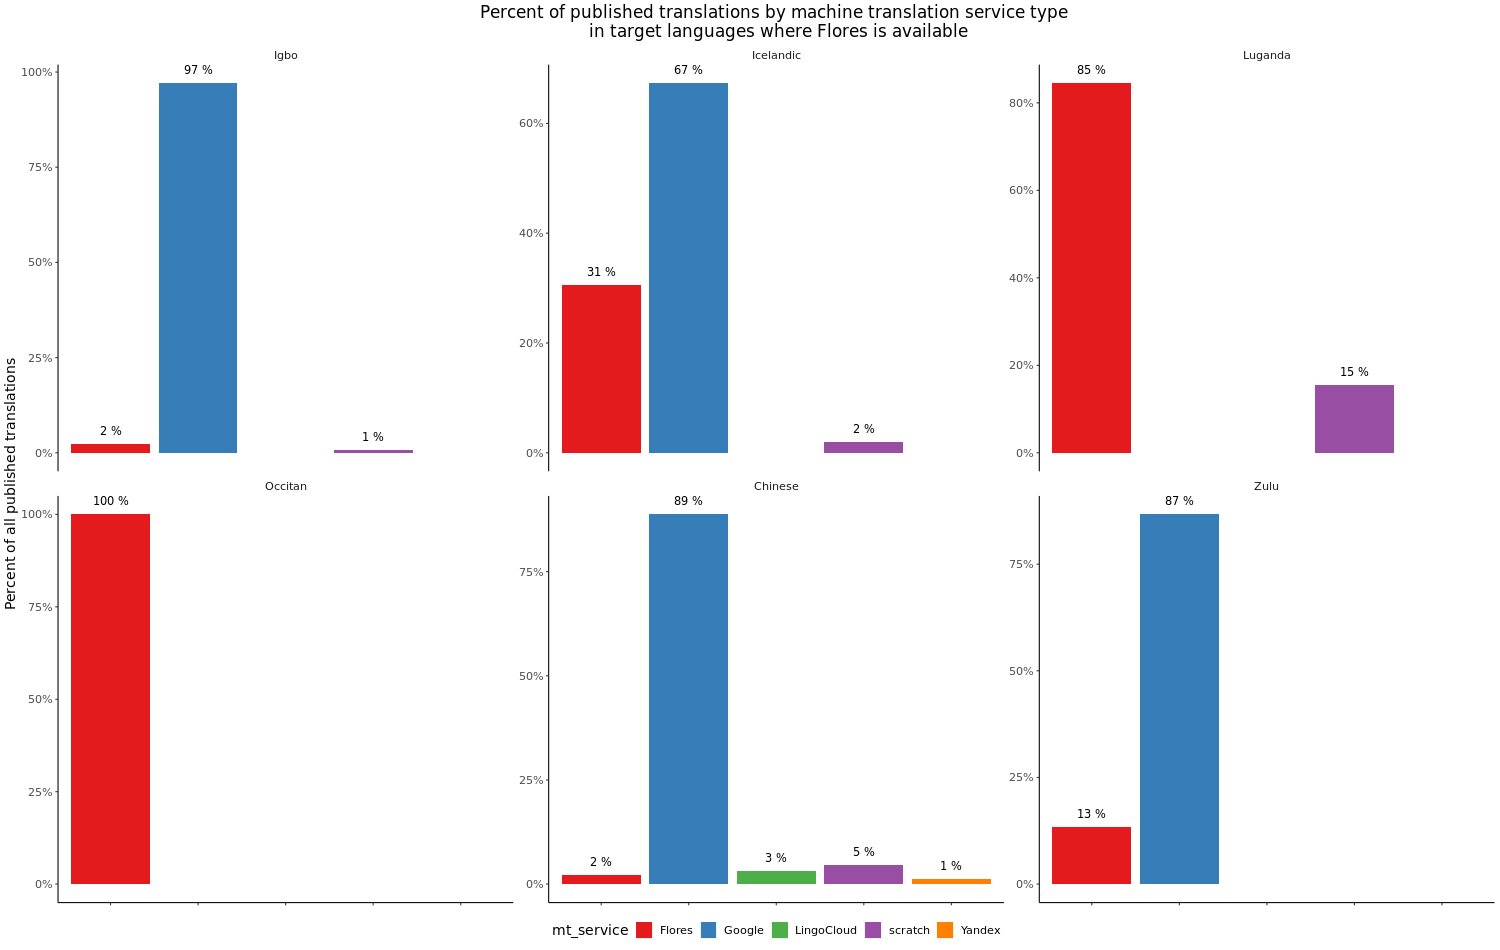

In [11]:
%%R -w 1500 -h 950
# Chart usage compared to other services
p <- flores_usage_compare_pct %>%
        filter(target_language %in% c('Igbo', 'Icelandic' , 'Luganda', 'Occitan', 'Chinese', 'Zulu')) %>%
        ggplot(aes(x = mt_service, y= pct_translations, fill = mt_service)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(round(pct_translations * 100,0), "%")), color = "black", vjust=-1, size = 4) +
        scale_y_continuous(labels = scales::percent) +
        facet_wrap(~target_language, scale = 'free_y') +
        labs (x = "Machine translation service",
              y = "Percent of all published translations",
             title = "Percent of published translations by machine translation service type \n in target languages where Flores is available"
             ) +
         scale_fill_brewer(palette="Set1")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/flores_usage_compare_pct.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

Observations:
* As shown in the chart above, Flores has been used for a small percentage of translations published since deployment at Igbo (2%) and Chinese (2%) languages and slightly higher percentage at Zulu (13%) since it's deployment. Google is still the primary machine translation service used at these languages.
* Flores has been used to translate 31% of published translations for the Icelandic target language since deployment.
* Flores is used for 100% of published translations at Occitan and the majority of translations (85%) at Luganda (13% of translations were identifed as having no mt service being used (`cxc_origin = 'scratch'`), which is expected as it was enabled by default for these langauges.


## Time series chart of Flores usage at each target language

In [12]:
%%R
# convert time sent to date time
mt_data$translation_start_time <- as.Date(mt_data$translation_start_time, format = "%Y%m%d%H%M%S")

In [ ]:
### Only Flores

R[write to console]: `summarise()` has grouped output by 'translation_start_time'. You can override
using the `.groups` argument.



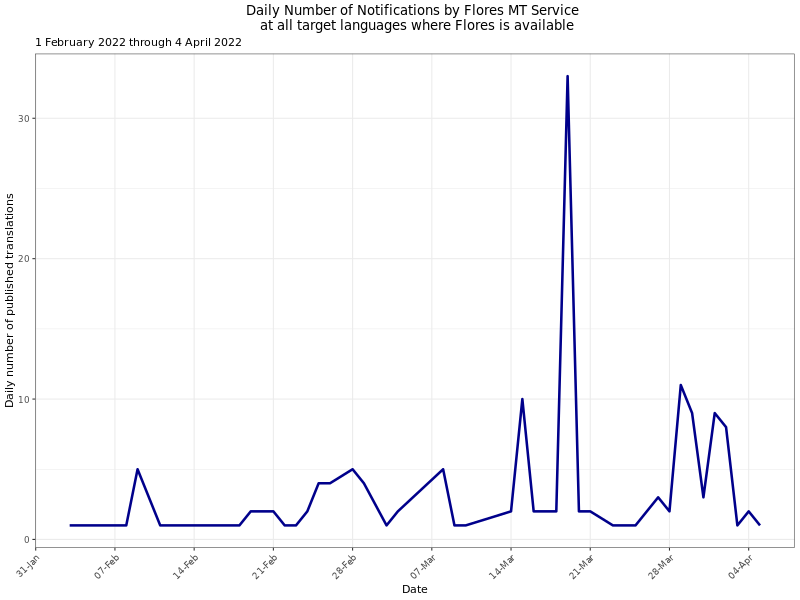

In [13]:
%%R -w 800 -h 600
flores_usage_overtime <- mt_data %>%
#limit to only languages where available
    filter(mt_service == 'Flores', #rnly Flores publications
          translation_start_time >= '2022-02-01')  %>%  #only translations started after deployment date
    group_by(translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id))  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations)) +
    geom_line(size = 1.2, color = 'darkblue') +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily Number of Notifications by Flores MT Service \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 4 April 2022")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

ggsave("Figures/flores_usage_overtime.png", p, width = 16, height = 8, units = "in", dpi = 300)

flores_usage_overtime

Since deployment of the service, there has been a gradual increase in the average daily number of translations that used Flores at all target languages where available. There was a signficant spike in translations on 19 March 2022, where there were 32 translations on 1 day at Luganda Wikipedia.

R[write to console]: `summarise()` has grouped output by 'translation_start_time'. You can override
using the `.groups` argument.



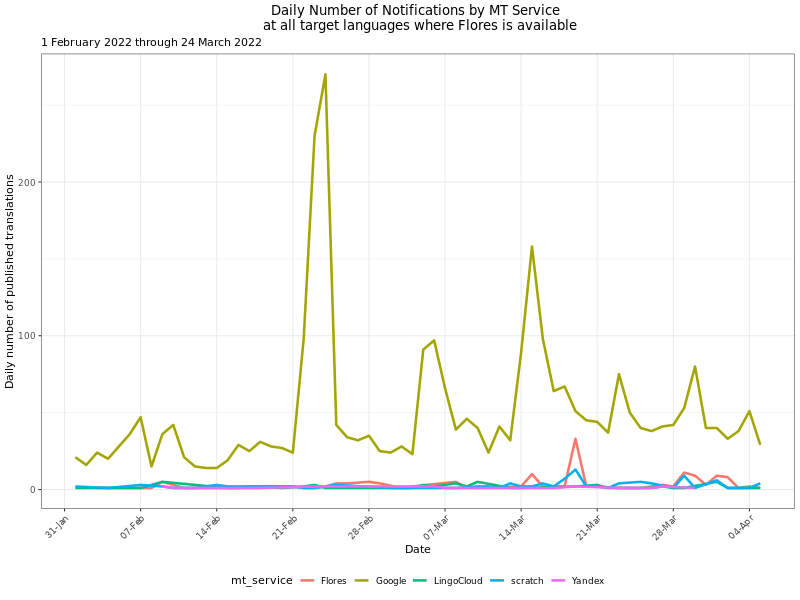

In [15]:
%%R -w 800 -h 600
flores_usage_overtime_bywiki <- mt_data %>%
#limit to only languages where available
    filter(source_language == 'en',
          target_language %in% c('ig','is', 'lg', 'oc', 'zh', 'zu'),
          translation_status == 'mt_engine', #remove source and user translations
          translation_start_time >= '2022-02-01')  %>%  #only translations started after deployment date
    group_by(translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id))  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations, color = mt_service)) +
    geom_line(size = 1.2) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily Number of Notifications by MT Service \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 24 March 2022")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

flores_usage_overtime_bywiki

## By Target Language

R[write to console]: `summarise()` has grouped output by 'target_language',
'translation_start_time'. You can override using the `.groups` argument.

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



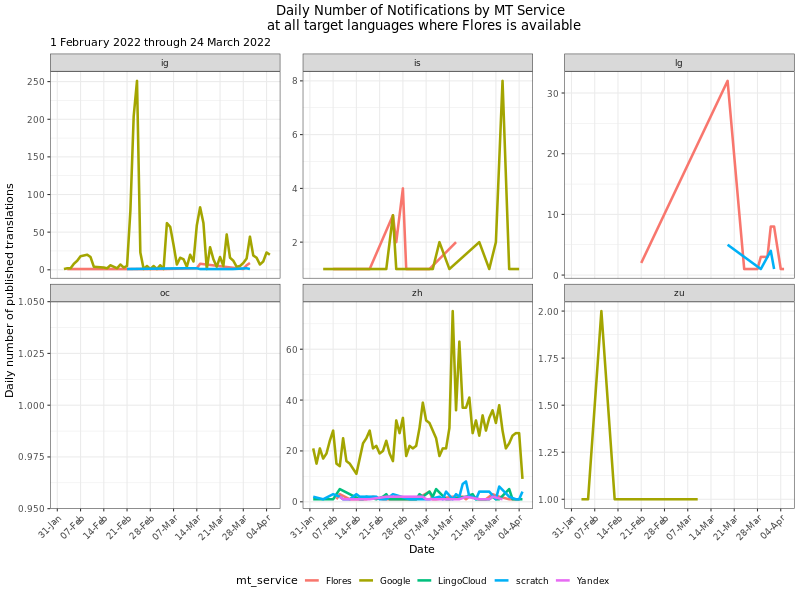

In [16]:
%%R -w 800 -h 600
flores_usage_overtime_bylang <- mt_data %>%
#limit to only languages where available
    filter(source_language == 'en',
          target_language %in% c('ig','is', 'lg', 'oc', 'zh', 'zu'),
          translation_status == 'mt_engine', #remove source and user translations
          translation_start_time >= '2022-02-01')  %>%  #only translations started after deployment date
    group_by(target_language, translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id))  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations, color = mt_service)) +
    geom_line(size = 1.2) +
    facet_wrap(~target_language, scale = 'free_y') +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily Number of Notifications by MT Service \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 24 March 2022")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

flores_usage_overtime_bylang 

The spike in published translations using Flores occured at Luganda Wikipedia on 19 March 2022. There were no spikes in translations at the other available MT services or target languages on this day. 

# How many translations are published using Flores (also as percentage of the total for the language)?

In [17]:
%%R
head(flores_usage_compare_pct)

# A tibble: 6 × 3
# Groups:   target_language [2]
  target_language mt_service pct_translations
  <fct>           <chr>                 <dbl>
1 Igbo            Flores              0.0223 
2 Igbo            Google              0.971  
3 Igbo            scratch             0.00677
4 Icelandic       Flores              0.306  
5 Icelandic       Google              0.673  
6 Icelandic       scratch             0.0204 


In [19]:
%%R
# usage of flores in different langauges where available
flores_usage_total <- flores_usage_compare_pct %>%
    filter(mt_service == 'Flores') %>%
    mutate(pct_translations = paste(round(pct_translations * 100, 2), "%"))
    
flores_usage_total

# A tibble: 6 × 4
# Groups:   target_language [6]
  target_language mt_service num_mt_translations pct_translations
  <fct>           <chr>                    <int> <chr>           
1 Igbo            Flores                      33 2.23 %          
2 Icelandic       Flores                      15 30.61 %         
3 Luganda         Flores                      60 84.51 %         
4 Occitan         Flores                       1 100 %           
5 Chinese         Flores                      43 2.28 %          
6 Zulu            Flores                       2 13.33 %         


# Which is the deletion rate for the articles created using Flores? [IN PROGRESS]

Method:
I originally tried to used the revision_id but most were missing are marked as NA so I'm investigating other methods. Do we know why some translations are missing revision_ids? Looks like this may be due to translations prior the addition of these two fields.

In [30]:
%%R
# obtain list of translation ids for all Flores Articles
flores_data <- mt_data %>%
    filter(mt_service == 'Flores')

    #!is.na(revision_id))


In [31]:
%R -o flores_data

In [32]:
flores_articles = flores_data["page_title"]
f = ','.join([str(u) for u in flores_articles])

flores_list = f.split(',')
flores_list_new = ','.join([str(u) for u in flores_list])
#flores_list = ','.join([f'{str(i)}' for i in f])

In [33]:
flores_articles = flores_data["page_title"].unique()

In [47]:
#obtain deletion ratio for all articles on target language wikis since FLores was deployed
query = """
-- find both cx and non-cx created articles 
WITH created_articles AS (

SELECT
    wiki_db AS wiki,
    SUM(CAST(ARRAY_CONTAINS(revision_tags, 'contenttranslation') AS INT)) AS created_cx,
    COUNT(*) AS created_total
FROM wmf.mediawiki_history
WHERE
    snapshot = '2022-02'
    AND event_timestamp >= '2022-02-01' 
-- interested in main page namespaces
    AND page_namespace = 0
-- only look at new page creations
    AND revision_parent_id = 0
    AND event_entity = 'revision'
    AND event_type = 'create' 
    AND wiki_db IN ('igwiki','iswiki', 'lgwiki', 'ocwiki', 'zhwiki', 'zuwiki')
GROUP BY  
  wiki_db
),

--find all deleted articles that were created with cx 

deleted_articles AS (

SELECT
    wiki_db AS wiki,
    SUM(CAST(ARRAY_CONTAINS(revision_tags, 'contenttranslation') AS INT)) AS deleted_cx,
    COUNT(*) AS deleted_total
FROM wmf.mediawiki_history
WHERE
       snapshot = '2022-02'
    AND event_timestamp >= '2022-02-01' 
-- interested in main page namespaces
    AND page_namespace = 0
-- only look at new page creations
    AND revision_parent_id = 0
    AND event_entity = 'revision'
-- find revisions moved to the archive table
    AND event_type = 'create'
    AND revision_is_deleted_by_page_deletion = TRUE
-- remove all bots
    AND SIZE(event_user_is_bot_by_historical) = 0  -- not a bot
    AND wiki_db IN ('igwiki','iswiki', 'lgwiki', 'ocwiki', 'zhwiki', 'zuwiki')
GROUP BY  
  wiki_db
)

-- main query to aggregate and join sources above
SELECT
    created_articles.wiki,
    created_cx,
    (created_total - created_cx)  AS created_non_cx,
    deleted_cx,
    (deleted_total - deleted_cx) AS deleted_non_cx
FROM created_articles
JOIN deleted_articles ON 
    created_articles.wiki = deleted_articles.wiki
"""

In [48]:
deletion_data = hive.run(query)

In [52]:
%%R -i deletion_data
# import df from global environment

NULL


In [56]:
%%R 
# Add columns with calculated deletion ratio

cx_deletion_ratio_bywiki <- deletion_data  %>%
    mutate(deleted_cx_ratio = paste0(round(deleted_cx/created_cx *100, 2), "%"),
           deleted_non_cx_ratio = paste0(round(deleted_non_cx/created_non_cx  *100, 2), "%"),
           deletion_ratio_diff = ((deleted_non_cx/created_non_cx)-(deleted_cx/created_cx)
           ))
    
cx_deletion_ratio_bywiki

    wiki created_cx created_non_cx deleted_cx deleted_non_cx deleted_cx_ratio
0 ocwiki          3            159          0              6               0%
1 igwiki        470             13          0              8               0%
2 zuwiki          1             18          0              3               0%
3 iswiki         14            178          1             35            7.14%
4 zhwiki        522          12814          8            755            1.53%
  deleted_non_cx_ratio deletion_ratio_diff
0                3.77%          0.03773585
1               61.54%          0.61538462
2               16.67%          0.16666667
3               19.66%          0.12520064
4                5.89%          0.04359426


Since Flores was deployed, articles created using content translation have only deen deleted at Icelandic and Chinese target languages. These deletion ratios are below the deletion ratio for articles created without using content translation during this time period. Further work needs to be done to isolate this only to FLores created articles.

# How much is the initial translation modified by users when using Flores?

For the purpose of this analyis, I reviwed the percent the intial translation was modified by users into three catergories: less than 10%, between 11 and 50%, and over 50%. These categories can be adjusted as needed. 

In [21]:
%%R
# Flores modifications by percent modified

flores_modification <- mt_data %>%
   filter(mt_service == 'Flores')  %>%  #only translations started after deployment date') %>%
    mutate(pct_human_modified = case_when(
        human_translated_percent < 0.10  ~ "less than 10%",
         (human_translated_percent >= 0.10 &  human_translated_percent < 0.51) ~ "between 11 and 50%",
         human_translated_percent >= 0.51  ~  "over 50%"),
          pct_human_modified = factor(pct_human_modified, 
                                        levels=c("less than 10%","between 11 and 50%","over 50%")),
          target_language = factor(target_language, 
                                               levels = c('ig','is', 'lg', 'oc', 'zh', 'zu'),
                                              labels = c('Igbo', 'Icelandic' , 'Luganda', 'Occitan', 'Chinese', 'Zulu')))
    

### Overall 

In [22]:
%%R
# find percent mt modified by languages where Flores is available
flores_modification_overall <- flores_modification %>%
    group_by(pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    ungroup() %>%
    summarise(pct_human_modified,
            num_translations,
              pct_translations = paste0(round(num_translations/sum(num_translations) * 100,2), "%")) 
    
flores_modification_overall

# A tibble: 3 × 3
  pct_human_modified num_translations pct_translations
  <fct>                         <int> <chr>           
1 less than 10%                    77 46.39%          
2 between 11 and 50%               70 42.17%          
3 over 50%                         19 11.45%          


The majorty of translations (88%) published using Flores were modified less than 50% by users at all target languages where available. 11% of Flores translations were modified over 50%.

## By Target Language

In [23]:
%%R
# find percent mt modified by languages where Flores is available
flores_modification_bytarget <- flores_modification %>%
    group_by(target_language, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id))  %>%
    group_by(target_language) %>%
    summarise(pct_human_modified,
            num_translations,
              pct_translations = num_translations/sum(num_translations))
    
flores_modification_bytarget

R[write to console]: `summarise()` has grouped output by 'target_language'. You can override using
the `.groups` argument.

R[write to console]: `summarise()` has grouped output by 'target_language'. You can override using
the `.groups` argument.



# A tibble: 14 × 4
# Groups:   target_language [6]
   target_language pct_human_modified num_translations pct_translations
   <fct>           <fct>                         <int>            <dbl>
 1 Igbo            less than 10%                    20           0.526 
 2 Igbo            between 11 and 50%               16           0.421 
 3 Igbo            over 50%                          2           0.0526
 4 Icelandic       less than 10%                     6           0.375 
 5 Icelandic       between 11 and 50%               10           0.625 
 6 Luganda         less than 10%                    26           0.419 
 7 Luganda         between 11 and 50%               23           0.371 
 8 Luganda         over 50%                         13           0.210 
 9 Occitan         between 11 and 50%                1           1     
10 Chinese         less than 10%                    24           0.511 
11 Chinese         between 11 and 50%               19           0.404 
12 Chinese   

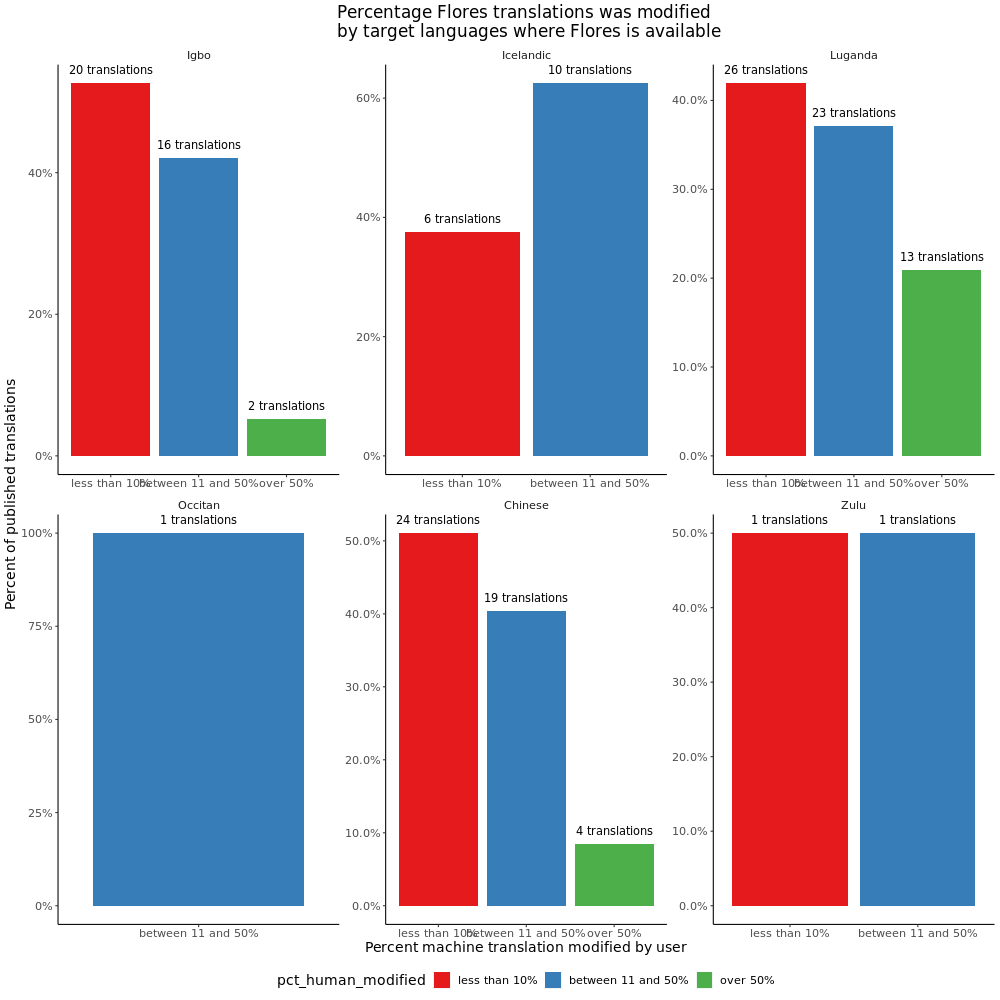

In [24]:
%%R -w 1000 -h 1000
# Chart usage compared to other services
p <- flores_modification_bytarget %>%
          ggplot(aes(x = pct_human_modified, y= pct_translations, fill = pct_human_modified)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(num_translations, " translations")), color = "black", vjust=-1, size = 4) +
        scale_y_continuous(labels = scales::percent) +
        facet_wrap(~ target_language, scales = "free") +
        labs (x = "Percent machine translation modified by user",
              y = "Percent of published translations",
             title = "Percentage Flores translations was modified \n by target languages where Flores is available"
             ) +
         scale_fill_brewer(palette="Set1")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            #axis.title.x=element_blank(),
            #axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
        ggsave("Figures/flores_modification_bytarget.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p
            

With the exception of Icelandic and Occitan (which only had 1 published translation), the largest number of published translations at each target language were modified less than 10% by users.